## **코드 실행환경**

Google Colab

Sklearn 버전 : 1.0.2

Pandas 버전 : 1.3.5

Numpy 버전 : 1.21.6

런타임 유형 : GPU

Linux-5.10.147+-x86_64-with-glibc2.27

Ubuntu 18.04.6 LTS

Python 3.8.16

GPU : NVIDIA-SMI 460.32.03 Driver Version: 460.32.03 CUDA Version: 11.2 Tesla T4

In [ ]:
import platform
platform.platform()

'Linux-5.10.147+-x86_64-with-glibc2.27'

In [ ]:
!cat /etc/issue.net

Ubuntu 18.04.6 LTS


In [ ]:
!python --version

Python 3.8.16


In [ ]:
!nvidia-smi

Tue Jan 17 14:15:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

구글 코랩 사용시 구글 드라이브 연결 사용

In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive')

#코랩 환경 경로 설정 -> 자신에게 맞는 경로로 설정해주시면 됩니다 
DATA_PATH = '/content/gdrive/MyDrive/유전체공모전/data/'

Mounted at /content/gdrive


## Import & Install

In [ ]:
# 코랩 기준 필요 라이브러리 설치

# Category_encoders 설치
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.5 MB/s eta 0:00:00


In [ ]:
#Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

#sklearn module & utils
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectPercentile
warnings.filterwarnings('ignore') 

#Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding
import category_encoders as ce

#Sampling
from imblearn.over_sampling import BorderlineSMOTE

#Modeling
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Fix Seed

In [ ]:
#Seed 고정
class CFG:
    SEED = 26

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [ ]:
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
snp = pd.read_csv(DATA_PATH + 'snp_info.csv')

## EDA

In [ ]:
#X Y 데이터분리 및 id column drop
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

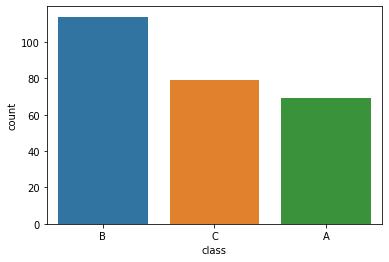

In [ ]:
#class imbalanced -> Oversampling 적용
sns.countplot(train_y)

## Data Pre-processing

In [ ]:
#train_x 데이터를 확인해본 결과, 동일한 값을 가지는 columns 제거 -> 모델링에 좋지 않은 영향을 줄 것으로 판단 
train_x = train_x.drop(columns=['father','mother','gender'])
test_x = test_x.drop(columns=['father','mother','gender'])

## Feature Engineering

In [ ]:
snp

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


*SNP 정보(name, chrom, cm, pos)를 활용하여 Feature Engineering을 진행하였습니다

1. name(SNP 명) & chrom(염색체 정보)
2. chrom(염색체 정보)
3. SNP Total combination
4. cm(Genetic distance)
5. SNP G,C,A mathematical feature

#### SNP 합

In [ ]:
train_x['2_BTA'] = train_x['SNP_01']
train_x['chrom_6'] = train_x['SNP_02'] + '-'+ train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09']
train_x['6_ARS_Parent'] = train_x['SNP_02']
train_x['6_ARS_BFGL'] = train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_09']
train_x['6_BOVINE'] = train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_08']
train_x['6_HAPMAP'] = train_x['SNP_07']
train_x['7_BTB'] = train_x['SNP_10']
train_x['8_ARS'] = train_x['SNP_11']
train_x['chrom_9'] = train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14']
train_x['9_HAPMAP'] = train_x['SNP_12'] + '-' + train_x['SNP_14']
train_x['9_BTB'] = train_x['SNP_13']
train_x['10_BOVINE'] = train_x['SNP_15']
train_x['SNP_total'] = train_x['SNP_01'] + '-' + train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09'] + '-' + train_x['SNP_10'] + '-' + train_x['SNP_11'] + '-' + train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14'] + '-' + train_x['SNP_15']  

In [ ]:
test_x['2_BTA'] = test_x['SNP_01']
test_x['chrom_6'] = test_x['SNP_02'] + '-'+ test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09']
test_x['6_ARS_Parent'] = test_x['SNP_02']
test_x['6_ARS_BFGL'] = test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_09']
test_x['6_BOVINE'] = test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_08']
test_x['6_HAPMAP'] = test_x['SNP_07']
test_x['7_BTB'] = test_x['SNP_10']
test_x['8_ARS'] = test_x['SNP_11']
test_x['chrom_9'] = test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14']
test_x['9_HAPMAP'] = test_x['SNP_12'] + '-' + test_x['SNP_14']
test_x['9_BTB'] = test_x['SNP_13']
test_x['10_BOVINE'] = test_x['SNP_15']
test_x['SNP_total'] = test_x['SNP_01'] + '-' + test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09'] + '-' + test_x['SNP_10'] + '-' + test_x['SNP_11'] + '-' + test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14'] + '-' + test_x['SNP_15'] 

#### 공백제거

In [ ]:
def blank(data_tr, data_te, columns):
    for i in columns :
        data_tr[i] = data_tr[i].apply(lambda x : x.replace(" ",""))
        data_te[i] = data_te[i].apply(lambda x : x.replace(" ",""))
        
    return data_tr, data_te

target_columns = train_x.iloc[:,16:].columns.to_list()
train_x.iloc[:,16:], test_x.iloc[:,16:] = blank(train_x.iloc[:,16:], test_x.iloc[:,16:], target_columns)

#### SNP A,C,G 값 개수

In [ ]:
train_x['concat'] = train_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
train_x['numGC'] = train_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
train_x['numA'] = train_x['concat'].apply(lambda x : x.count('A'))
train_x['numGC^2'] = train_x['numGC']**2
train_x['sub'] = train_x['numGC'] - train_x['numA']
train_x['H'] = train_x['numGC']*3 + train_x['numA']*2

In [ ]:
test_x['concat'] = test_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
test_x['numGC'] = test_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
test_x['numA'] = test_x['concat'].apply(lambda x : x.count('A'))
test_x['numGC^2'] = test_x['numGC']**2
test_x['sub'] = test_x['numGC'] - test_x['numA']
test_x['H'] = test_x['numGC']*3 + test_x['numA']*2

#### trait 변수 type 변환

In [ ]:
train_x['trait'] = train_x['trait'].astype('object')
test_x['trait'] = test_x['trait'].astype('object')

#### 범주형, 수치형 피처 구분

In [ ]:
cat_features = train_x.select_dtypes(include=['object']).columns.to_list()
num_features = train_x.select_dtypes(exclude=['object']).columns.to_list()

## Scaling

In [ ]:
scaler = StandardScaler()
train_x[num_features] = scaler.fit_transform(train_x[num_features])
test_x[num_features] = scaler.transform(test_x[num_features])

## Encoding

In [ ]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y)
    y_onehot = enc.transform(y)
    class_names = y_onehot.columns
    X_obj = X.select_dtypes('object')
    X_t_obj = X_t.select_dtypes('object')
    X = X.select_dtypes(exclude='object')
    X_t = X_t.select_dtypes(exclude='object') 
    for class_ in class_names:
        enc = ce.CatBoostEncoder()
        enc.fit(X_obj,y_onehot[class_])
        temp = enc.transform(X_obj)
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x)+'_'+str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp],axis=1)
        X_t = pd.concat([X_t,temp_t],axis=1)
      
    return X, X_t

train_x, test_x = catboost_encoder_multiclass(train_x,test_x,train_y)

## SMOTE

In [ ]:
# Class 불균형 문제 해결
train_x,train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x,train_y)

## Target Label-Encoding

In [ ]:
class_le = LabelEncoder()
train_y = class_le.fit_transform(train_y)

## Modeling & Ensemble

In [ ]:
#Submission file 준비
submit = pd.read_csv(DATA_PATH  + 'sample_submission.csv')

In [ ]:
#Model Selection -> 여러 모델링 실험결과 종류가 다른 모델 여러개를 앙상블 하는 것이 좋다 판단함
models = [
    ('bag', BaggingClassifier(random_state=CFG.SEED)),
    ('dt', DecisionTreeClassifier(random_state=CFG.SEED)),
    ('rc', RidgeClassifier(random_state=CFG.SEED)),
    ('xgb', XGBClassifier(random_state=CFG.SEED)),
    ('lgb', LGBMClassifier(random_state=CFG.SEED)),
    ('gb', GradientBoostingClassifier(random_state=CFG.SEED)),
    ('svc', SVC(random_state=CFG.SEED)),
    ('rcc', RidgeClassifierCV()),
    ('rf', RandomForestClassifier(random_state=CFG.SEED))
]

In [ ]:
#최종모델은 Votingclassifier 사용하여 ensemble -> 제출결과 public score기준 XGBClassifier와 RandomForestClassifier 성능이 좋아 가중치를 주었음
best_model  = VotingClassifier(models, voting='hard', weights=[1,1,1,2,1,1,1,1,2])
best_model.fit(train_x,train_y)

VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=26)),
                             ('dt', DecisionTreeClassifier(random_state=26)),
                             ('rc', RidgeClassifier(random_state=26)),
                             ('xgb', XGBClassifier(random_state=26)),
                             ('lgb', LGBMClassifier(random_state=26)),
                             ('gb',
                              GradientBoostingClassifier(random_state=26)),
                             ('svc', SVC(random_state=26)),
                             ('rcc',
                              RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))),
                             ('rf', RandomForestClassifier(random_state=26))],
                 weights=[1, 1, 1, 2, 1, 1, 1, 1, 2])

## Submit

In [ ]:
#test predict
pred = class_le.inverse_transform(best_model.predict(test_x))
submit['class'] = pred

In [ ]:
submit

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [ ]:
submit.to_csv('Fine_20.csv',index=False)